<a href="https://colab.research.google.com/github/greenkode/pytorch/blob/master/Chapter_6_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import IPython.display as display
from torch.utils.data import Dataset

In [2]:
# !git clone https://github.com/karoldvl/ESC-50
# !mkdir ESC-50/train ESC-50/test ESC-50/valid

# !mv ESC-50/audio/1* ESC-50/train 
# !mv ESC-50/audio/2* ESC-50/train 
# !mv ESC-50/audio/3* ESC-50/train 
# !mv ESC-50/audio/4* ESC-50/valid 
# !mv ESC-50/audio/5* ESC-50/test
# !pip install torchaudio

In [3]:
import glob
from collections import Counter

# esc50_list = [f.split("-")[-1].replace(".wav", "") 
#               for f in glob.glob("ESC-50/audio/*.wav")]
# Counter(esc50_list)

In [4]:
from pathlib import Path
import torchaudio
import torch

class ESC50(Dataset):
  def __init__(self, path):
    # Get directory listing from path
    files = Path(path).glob('*.wav')
    # Iterate through the listing and create a list of tuples(filename ,label)
    self.items = [(f, int(f.name.split("-")[-1].replace(".wav", ""))) 
                    for f in files]
    self.length = len(self.items)

  def __getitem__(self, index):
    filename, label = self.items[index]
    audio_tensor, sample_rate = torchaudio.load(filename)
    return audio_tensor, label

  def __len__(self):
    return self.length

In [5]:
bs = 64
PATH_TO_ESC50 = Path.cwd() / 'ESC-50'
path = 'test.md'

train_esc50 = ESC50(PATH_TO_ESC50 / "train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "valid")
test_esc50 = ESC50(PATH_TO_ESC50 / "test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size=bs, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_esc50, batch_size=bs, shuffle=True)

In [6]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [7]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class AudioNet(nn.Module):
  def __init__(self):
    super(AudioNet, self).__init__()
    self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
    self.bn1 = nn.BatchNorm1d(128)
    self.pool1 = nn.MaxPool1d(4)
    self.conv2 = nn.Conv1d(128, 128, 3)
    self.bn2 = nn.BatchNorm1d(128)
    self.pool2 = nn.MaxPool1d(4)
    self.conv3 = nn.Conv1d(128, 256, 3)
    self.bn3 = nn.BatchNorm1d(256)
    self.pool3 = nn.MaxPool1d(4)
    self.conv4 = nn.Conv1d(256, 512, 3)
    self.bn4 = nn.BatchNorm1d(512)
    self.pool4 = nn.MaxPool1d(4)
    self.fc1 = nn.Linear(512, 50)
  
  def forward(self, x):
    x = x.unsqueeze(-1).view(-1, 100, 2205)
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.pool3(x)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = self.pool4(x)
    x = x.squeeze(-1)
    x = self.fc1(x)
    return x

In [9]:
device = "cuda"
audio_net = AudioNet()
audio_net.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

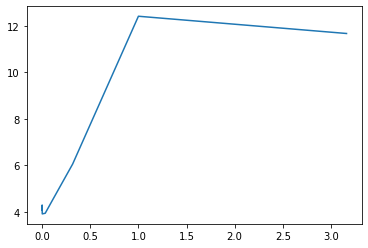

In [10]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

torch.save(audio_net.state_dict(), "audionet.pth")
optimizer = optim.Adam(audio_net.parameters(), lr=0.001)
logs, losses = find_lr(audio_net, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)
plt.plot(logs, losses)

In [11]:
lr = 1e-5
audio_net.load_state_dict(torch.load("audionet.pth"))
optimizer = optim.Adam(audio_net.parameters(), lr=lr)

train(audio_net, optimizer, torch.nn.CrossEntropyLoss(), train_loader, valid_loader, epochs=20, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 4.09, Validation Loss: 3.92, accuracy = 0.02
Epoch: 1, Training Loss: 3.94, Validation Loss: 3.90, accuracy = 0.01
Epoch: 2, Training Loss: 3.84, Validation Loss: 3.86, accuracy = 0.03
Epoch: 3, Training Loss: 3.77, Validation Loss: 3.84, accuracy = 0.03
Epoch: 4, Training Loss: 3.71, Validation Loss: 3.82, accuracy = 0.04
Epoch: 5, Training Loss: 3.66, Validation Loss: 3.80, accuracy = 0.04
Epoch: 6, Training Loss: 3.61, Validation Loss: 3.78, accuracy = 0.04
Epoch: 7, Training Loss: 3.57, Validation Loss: 3.77, accuracy = 0.05
Epoch: 8, Training Loss: 3.52, Validation Loss: 3.76, accuracy = 0.05
Epoch: 9, Training Loss: 3.49, Validation Loss: 3.75, accuracy = 0.05
Epoch: 10, Training Loss: 3.46, Validation Loss: 3.74, accuracy = 0.05
Epoch: 11, Training Loss: 3.43, Validation Loss: 3.73, accuracy = 0.05
Epoch: 12, Training Loss: 3.39, Validation Loss: 3.72, accuracy = 0.05
Epoch: 13, Training Loss: 3.35, Validation Loss: 3.72, accuracy = 0.05
Epoch: 14, Train

In [13]:
import librosa
from librosa import display
import numpy as np

sample_data, sr = librosa.load("ESC-50/train/1-100032-A-0.wav", sr=None)
spectrogram = librosa.feature.melspectrogram(sample_data, sr=sr)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

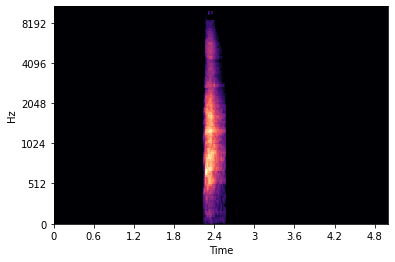

In [14]:
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

In [23]:
import torchvision
import time
from torchvision import models, transforms

class ESC50Spectrogram(Dataset):

  def __init__(self, path, transforms=None):
    files = Path(path).glob('*.wav')
    self.items = [(f, int(f.name.split("-")[-1].replace(".wav", ""))) for f in files]
    self.length = len(self.items)
    self.transforms = transforms

  def __getitem__(self, index):
    filename, label = self.items[index]
    audio_tensor, sample_rate = librosa.load(filename, sr=None)
    spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sample_rate)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    fig = plt.gcf()
    fig.canvas.draw()
    audio_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    audio_data = audio_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return (self.transforms(audio_data), label)

  def __len__(self):
    return self.length

(0.002616863999989505, 0.37588689899999395)

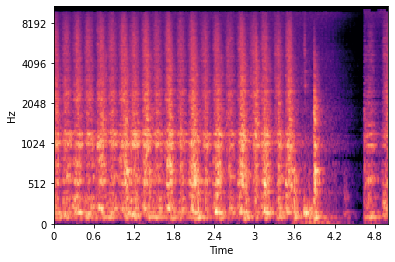

In [26]:
oldESC50 = ESC50("ESC-50/train/") 
start_time = time.process_time() 
oldESC50.__getitem__(33) 
end_time = time.process_time() 
old_time = end_time - start_time

newESC50 = ESC50Spectrogram("ESC-50/train/", transforms.Compose([transforms.ToTensor()])) 
start_time = time.process_time() 
newESC50.__getitem__(33)
end_time = time.process_time()
new_time = end_time - start_time

old_time, new_time

In [27]:
def precompute_spectrograms(path, dpi=50):
  files = Path(path).glob('*.wav')
  for filename in files:
    audio_tensor, sample_rate = librosa.load(filename, sr=None)
    spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.gcf().savefig("{}{}_{}.png".format(filename.parent, dpi, filename.name), dpi=dpi)

In [ ]:
precompute_spectrograms(PATH_TO_ESC50/'train')
precompute_spectrograms(PATH_TO_ESC50/'test')
precompute_spectrograms(PATH_TO_ESC50/'valid')

In [29]:
from PIL import Image

class PrecomputedESC50(Dataset):
  def __init__(self, path, dpi=50, transforms=None):
    files = Path(path).glob('{}*.wav.png'.format(dpi))
    self.items = [(f, int(f.name.split("-")[-1].replace(".wav.png", ""))) for f in files]
    self.length = len(self.items)
    if transforms == None:
      self.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    else:
      self.transforms = transforms
    
    def __getitem__(self, index):
      filename, label = self.items[index]
      img = Image.open(filename)
      return (self.transforms(img), label)

    def __len__(self):
      return self.length

In [ ]:
start_time = time.process_time()
b.__getitem__(33)
end_time = time.process_time()
end_time - start_time

In [ ]:
from torchvision import models
spec_resnet = models.ResNet50(pretrained=True)

for param in spec_resnet.parameters():
  param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500), nn.ReLU(), nn.Dropout(), nn.Linear(500, 50))

In [ ]:
esc50pre_train = PreparedESC50(PATH, transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

esc50pre_valid = PreparedESC50(PATH, transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

esc50_train_loader = (esc50pre_train, bs, shuffle=True)
esc50_valid_loader = (esc50pre_valid, bs, shuffle=True)

In [ ]:
spec_resnet.save('spec_resnet.pth')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
logs, losses = find_lr(spec_resnet, loss_fn, optimizer)
plt.plot(logs, losses)

In [ ]:
optimizer = optim.Adam(spec_resnet.parameters(), lr=[1e-2, 1e-4, 1e-8])
train(spec_resnet, optimizer, nn.CrossEntropyLoss(),
      esc50_train_loader, esc50_val_loader, epochs=5, device='cuda')

In [ ]:
for param in spec_resnet.parameters():
  param.requires_grad = True

In [ ]:
optimizer = optim.Adam(spec_resnet.parameters(), lr=[1e-2, 1e-4, 1e-8])
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=20, device='cuda')

# Audio Augmentation

In [ ]:
audio_tensor, rate = torchaudio.load("test.wav")
audio_tensor.shape
tripped_tensor = torchaudio.transforms.PadTrim(max_len=1000)(audio_orig)

# **SoX Effect**

In [ ]:
class ESC50WithPitchChange(Dataset):
  def __init__(self, path):
    files = Path(path).glob('*.wav')
    # Iterate through the listing and create a list of tuples (filename, label) 
    self.items = [(f,f.name.split("-")[-1].replace(".wav","")) for f in files]
    self.length = len(self.items)
    self.E = torchaudio.sox_effects.SoxEffectsChain()
    self.E.append_effect_to_chain("pitch", [0.5])
  
  def __getitem__(self, index):
    filename, label = self.items[index]
    self.E.set_input_file(filename)
    audio_tensor, sample_rate = self.E.sox_build_flow_effects()
    return audio_tensor, label

  def __len__(self):
    return self.length

In [ ]:
class FrequencyMask(object):
  """
    Example:
      >>> transforms.Compose([
      >>>   transforms.ToTensor(),
      >>>   FrequencyMask(max_width=10, use_mean=False),
      >>> ])
  """

  def __init__(self, max_width, use_mean=True):
    self.max_width = max_width
    self.use_mean = use_mean

  def __call__(self, tensor)
    """
    Args:
      tensor (Tensor): Tensor image of size (C, H, W) where the frequency mask
      is to be applied

    Returns:
      Tensor: Transformed image with Frequency Mask.
    """
    start = random.randrange(0, tensor.shape[2])
    end = start + random.randrange(1, self.max_width)
    if self.use_mean:
      tensor[:, start:end, :] = tensor.mean()
    else:
      tensor[:, start:end, :] = 0
    return tensor
  
  def __repr__(self):
    format_string = self.__class__.__name__ + "(max_width="
    format_string += str(self.max_width) + ")"
    format_string += 'use_mean=' + (str(self.use_mean) + ')')

    return format_string

In [ ]:
torchvision.transforms.Compose([FrequencyMask(max_width=10, use_mean=False), 
                                torchvision.transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class TimeMask(object):
  """
    Example:
      >>> transforms.Compose([
      >>>   transforms.ToTensor(),
      >>>   TimeMask(max_width=10, use_mean=False),
      >>> ])
  """

  def __init__(self, max_width, use_mean=True):
    self.max_width = max_width
    self.use_mean = use_mean

  def __call__(self, tensor)
    """
    Args:
      tensor (Tensor): Tensor image of size (C, H, W) where the time mask
      is to be applied

    Returns:
      Tensor: Transformed image with Frequency Mask.
    """
    start = random.randrange(0, tensor.shape[1])
    end = start + random.randrange(1, self.max_width)
    if self.use_mean:
      tensor[:, :, start:end] = tensor.mean()
    else:
      tensor[:, :, start:end] = 0
    return tensor
  
  def __repr__(self):
    format_string = self.__class__.__name__ + "(max_width="
    format_string += str(self.max_width) + ")"
    format_string += 'use_mean=' + (str(self.use_mean) + ')')

    return format_string

In [ ]:
torchvision.transforms.Compose([TimeMask(max_width=10, use_mean=False), 
                                torchvision.transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class PrecomputedTransformESC50(Dataset):
  def __init__(self,path,dpi=50):
    files = Path(path).glob('{}*.wav.png'.format(dpi))
    self.items = [(f, f.name.split("-")[-1].replace(".wav.png", "")) for f in files]
    self.length = len(self.items)
    self.transforms = transforms.Compose([
                                          transforms.ToTensor(),
                                          RandomApply([FrequencyMask(self.max_freqmask_width)]p=0.5),
                                          RandomApply([TimeMask(self.max_timemask_width)]p=0.5)
    ])
  def __getitem__(self, index):
    filename, label = self.items[index]
    img = Image.open(filename)
    return (self.transforms(img), label)

  def __len__(self):
    return self.length